# Imports

In [1]:
import yfinance as yf # using yahoo finance api
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

# Utils

In [2]:
def ensure_column(df, col_name, generator_func, override=False):
    """
    Ensures a column exists in the DataFrame. If it doesn't exist or override=True, generates it.

    Parameters:
        df (pd.DataFrame): The DataFrame to modify.
        col_name (str): The name of the column to check.
        generator_func (callable): A function that generates the column values when needed.
        override (bool): If True, forces recalculation by dropping the column first.

    Returns:
        None (modifies the DataFrame in place)
    """
    if override and col_name in df.columns:
        df.drop(columns=[col_name], level=0, inplace=True)  # Remove the column before recomputing, to avoid recompute errors
    
    if col_name not in df.columns:  # Only generate if it doesn't exist
        df[col_name] = generator_func()


# Data Collection

In [3]:
# Define stock ticker symbol
ticker = "NVDA"

# Fetch historical stock data from Yahoo Finance
nvda = yf.download(ticker, start="2019-01-01", end="2024-01-01")

# Display first few rows
nvda.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2019-01-02,3.377779,3.433819,3.224785,3.239415,508752000
2019-01-03,3.173704,3.351495,3.166265,3.317523,705552000
2019-01-04,3.377035,3.415221,3.216105,3.246853,585620000
2019-01-07,3.555818,3.592765,3.382987,3.434316,709160000
2019-01-08,3.467295,3.639631,3.394641,3.637399,786016000


# Quick Look

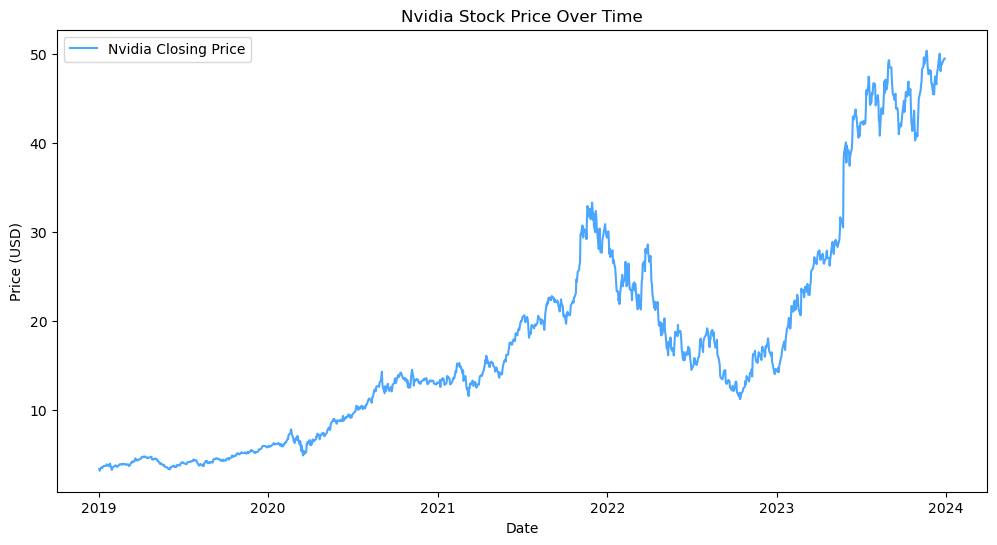

In [34]:
plt.figure(figsize=(12,6))
plt.plot(nvda["Close"], label="Nvidia Closing Price", color='dodgerblue', alpha=0.8)
plt.title("Nvidia Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

### Thoughts

This is really cool, knowing what's been happening the last 5 years, you see the constant rise during covid, where everyone was getting a gaming computer or buying gpus for their existing computer. I'm shocked to see that drop late 2022, but I do remember something about the US government asking Nvidia to not sell to China and also the issue with not getting computer chips, and that might be why. then you see the rise again when you came, OpenAI's "first" chatgpt and every company was rushing to either finish or produce something similar so the demand for gpus rose again. So in summary:

* **2020-2021 Boom** &rarr; COVID lockdowns &rarr; Higher gaming & AI demand &rarr; GPU shortages &rarr; Stock surged.

* **Late 2022 Drop** &rarr; US Government restrictions on AI chips to China + global semiconductor shortage.

* **2023-Present Rebound** &rarr; OpenAI’s ChatGPT launch &rarr; Massive AI adoption &rarr; Nvidia dominates AI GPU market.

For financial data, it's crucial to understand global events and resource management, as these factors directly impact supply and demand. Changes in supply and demand, in turn, influence stock prices for publicly traded companies. Even for non-public entities, such economic shifts affect investors, funding opportunities, and overall market sentiment.

# Digging Deeper

## Rolling Averages, Golden Crosses & Death Crosses

In [49]:
# Short-term and long-term rolling averages
window_short_term = 50
window_long_term = 200

ensure_column(nvda, f"MA_{window_short_term}", lambda: nvda["Close"].rolling(window=window_short_term, center=True).mean())
ensure_column(nvda, f"MA_{window_long_term}", lambda: nvda["Close"].rolling(window=window_long_term, center=True).mean())

# Using Exponential moving average (EMA) gives more weight to recent data, which is more relevant for golden & death crosses
ensure_column(nvda, f"EMA_{window_short_term}", lambda: nvda["Close"].ewm(span=window_short_term, adjust=False).mean())
ensure_column(nvda, f"EMA_{window_long_term}", lambda: nvda["Close"].ewm(span=window_long_term, adjust=False).mean())

# Identify where the 50-day MA crosses above the 200-day MA (Golden Cross)
# golden_crosses = (
#     (nvda[f"MA_{window_short_term}"].shift(1) < nvda[f"MA_{window_long_term}"].shift(1))
#     & (nvda[f"MA_{window_short_term}"] > nvda[f"MA_{window_long_term}"])
#     )

# Identify where the 50-day MA crosses below the 200-day MA (Death Cross)
# death_crosses = (
#     (nvda[f"MA_{window_short_term}"].shift(1) > nvda[f"MA_{window_long_term}"].shift(1))
#     & (nvda[f"MA_{window_short_term}"] < nvda[f"MA_{window_long_term}"])
#     )

# Identify where the 50-day EMA crosses above the 200-day EMA (Golden Cross)
golden_crosses = (
    (nvda[f"EMA_{window_short_term}"].shift(1) < nvda[f"EMA_{window_long_term}"].shift(1))
    & (nvda[f"EMA_{window_short_term}"] > nvda[f"EMA_{window_long_term}"])
    )

# Identify where the 50-day EMA crosses below the 200-day EMA (Death Cross)
death_crosses = (
    (nvda[f"EMA_{window_short_term}"].shift(1) > nvda[f"EMA_{window_long_term}"].shift(1))
    & (nvda[f"EMA_{window_short_term}"] < nvda[f"EMA_{window_long_term}"])
    )

# Get the dates of the crossovers
golden_cross_dates = nvda.index[golden_crosses]
death_cross_dates = nvda.index[death_crosses]

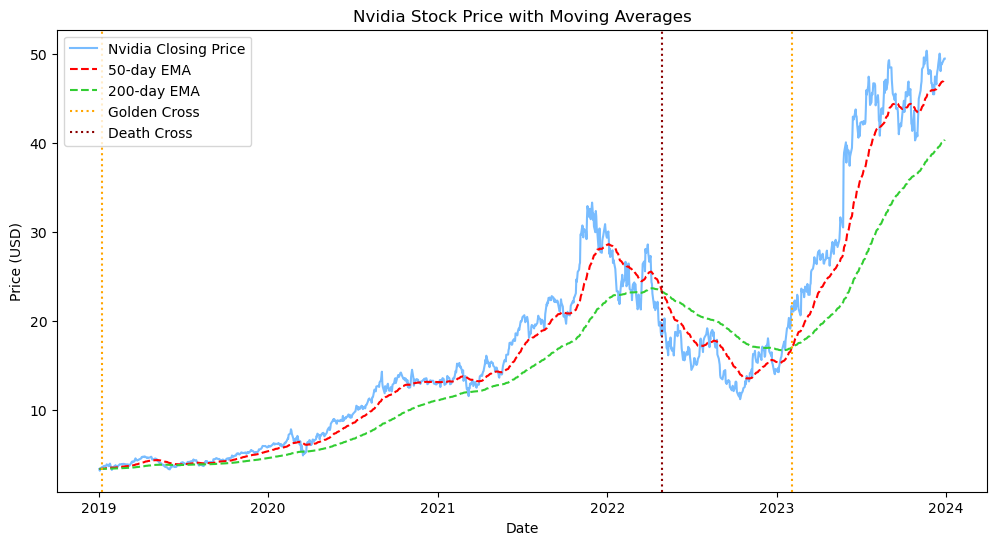

In [50]:
# Plot with moving averages
plt.figure(figsize=(12,6))
plt.plot(nvda["Close"], label="Nvidia Closing Price", color='dodgerblue', alpha=0.6)
# plt.plot(nvda[f"MA_{window_short_term}"], label=f"{window_short_term}-day MA", color='red', linestyle="--")
# plt.plot(nvda[f"MA_{window_long_term}"], label=f"{window_long_term}-day MA", color='limegreen', linestyle="--")
plt.plot(nvda[f"EMA_{window_short_term}"], label=f"{window_short_term}-day EMA", color='red', linestyle="--")
plt.plot(nvda[f"EMA_{window_long_term}"], label=f"{window_long_term}-day EMA", color='limegreen', linestyle="--")

# Annotate Golden Cross points
for date in golden_cross_dates:
    plt.axvline(date, color="orange", linestyle=":", alpha=1, label="Golden Cross" if date == golden_cross_dates[0] else "")

# Annotate Death Cross points
for date in death_cross_dates:
    plt.axvline(date, color="darkred", linestyle=":", alpha=1, label="Death Cross" if date == death_cross_dates[0] else "")


plt.title("Nvidia Stock Price with Moving Averages")
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

### Thoughts

#### Early 2022: Death Cross (good time to sell)

* The 50-day MA (green) crossed below the 200-day MA (red).
* This signaled a bearish trend, and Nvidia’s stock declined sharply afterward.
* This aligned with macroeconomic issues (chip shortages, US-China restrictions).

#### Early 2023: Golden Cross (good time to buy)

* The 50-day MA crossed above the 200-day MA, signaling a bullish reversal.
* Nvidia’s stock skyrocketed afterward, driven by the AI boom and demand for GPUs.

In [51]:
# Convert DataFrame column to a Series (1D)
nvda_volume = nvda.Volume.squeeze(axis=1)

# Ensure it's numeric
nvda_volume = pd.to_numeric(nvda_volume, errors="coerce")

# # This is to make it more noticeable (for heatmap plot)
# # Apply log transformation to amplify smaller volume changes
# volume_norm = np.log1p(nvda_volume - nvda_volume.min())

# # Normalize again to fit in [0,1]
# volume_norm = volume_norm / volume_norm.max()

# # Convert index to NumPy array
# dates = nvda.index.to_numpy()

In [8]:
# This is a really cool plot, though due to the constant volume (minus the outlier here and there),
# it's not a very interesting plot, but saving it for future reference

# import numpy as np
# import matplotlib.dates as mdates
# import matplotlib.colors as mcolors
# import matplotlib.cm as cm

# fig, ax1 = plt.subplots(figsize=(12,6))

# # First y-axis (Stock Price)
# ax1.set_xlabel("Date")
# ax1.set_ylabel("Price (USD)", color="black")
# ax1.plot(nvda.index, nvda["Close"], label="Nvidia Closing Price", color="black", alpha=0.8)
# ax1.tick_params(axis='y', labelcolor="black")

# # Choose a colormap (e.g., "coolwarm", "inferno", or "Purples")
# cmap = plt.get_cmap("plasma")  # Change this to "inferno" if you want

# # Generate colors for each point based on normalized volume
# norm = mcolors.Normalize(vmin=nvda["Volume-series"].min(), vmax=nvda["Volume-series"].max())
# sm = cm.ScalarMappable(cmap=cmap, norm=norm)  # Create ScalarMappable for colorbar
# sm.set_array([])  # Dummy array for colorbar

# colors = [cmap(v) for v in volume_norm]  # Map volume to color intensity

# # Fill-between with variable color intensity
# for i in range(len(nvda) - 1):  # Loop through each time step
#     x_vals = dates[i:i+2]  # Ensure x-axis values are NumPy array
#     y1 = np.full((2,), nvda["Close"].min())  # Ensure y1 is 1D
#     y2 = nvda["Close"][i:i+2].values.flatten()  # Ensure y2 is 1D

#     ax1.fill_between(x_vals, y1, y2, color=colors[i], alpha=0.6)  # Adjust alpha for visibility

# # Add colorbar to indicate trading volume
# cbar = plt.colorbar(sm, ax=ax1, orientation="vertical", fraction=0.05, pad=0.05)
# cbar.set_label("Trading Volume Intensity")

# # Title and Legends
# fig.suptitle("Nvidia Stock Price with Volume Heatmap Effect", fontsize=14)
# ax1.legend(loc="upper left")

# plt.show()

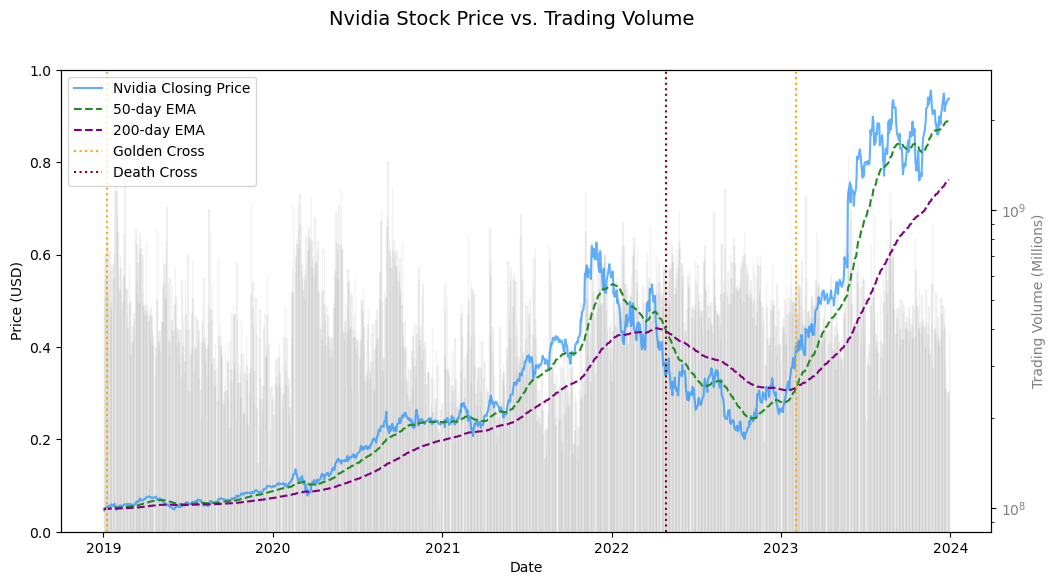

In [52]:
# Create figure and primary y-axis (empty for spacing)
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xlabel("Date")
ax1.set_ylabel("Price (USD)", color="black")

# Create second y-axis for Volume (bars)
ax2 = ax1.twinx()
ax2.set_ylabel("Trading Volume (Millions)", color="grey")
# ax2.bar(nvda.index, nvda_volume / 1_000_000, color="plum", alpha=0.8, width=2, label="Trading Volume", zorder=1)
ax2.bar(nvda.index, nvda_volume, facecolor="lightgrey", edgecolor="grey", alpha=0.1, width=1, zorder=1)
ax2.tick_params(axis='y', labelcolor="grey")
ax2.set_yscale("log")  # Keep log scale for better contrast

# Create third y-axis for Stock Price + MAs (these will be drawn last and will be shown OVER the volume)
ax3 = ax1.twinx()
# Dont need these axis since ax1 is there
ax3.spines["right"].set_visible(False)
ax3.set_axis_off()

# Stock price line (on ax3)
ax3.plot(nvda.index, nvda["Close"], label="Nvidia Closing Price", color="dodgerblue", alpha=0.7, zorder=3)
ax3.plot(nvda.index, nvda[f"EMA_{window_short_term}"], label=f"{window_short_term}-day EMA", color='forestgreen', linestyle="--", zorder=4)
ax3.plot(nvda.index, nvda[f"EMA_{window_long_term}"], label=f"{window_long_term}-day EMA", color='purple', linestyle="--", zorder=4)

# Annotate Golden & Death Crosses (on ax3)
for date in golden_cross_dates:
    ax3.axvline(date, color="orange", linestyle=":", alpha=1, label="Golden Cross" if date == golden_cross_dates[0] else "", zorder=5)
for date in death_cross_dates:
    ax3.axvline(date, color="darkred", linestyle=":", alpha=1, label="Death Cross" if date == death_cross_dates[0] else "", zorder=5)

# Title and Legends
fig.suptitle("Nvidia Stock Price vs. Trading Volume", fontsize=14)
ax3.legend(loc="upper left")

plt.show()

## Thoughts

The trading volume, which represents the market’s response to price movements, remains relatively stable—more so than I expected. This might be typical for widely followed stocks like Nvidia, where constant buying and selling occur regardless of short-term price fluctuations, as investors continue securing profits. The sustained activity could also be a byproduct of the stock’s volatility, which I plan to analyze next.

However, I noticed a slight drop in volume toward the end of 2023, suggesting that investors may have been hesitant, waiting to see whether the stock would break out or reverse. The price repeatedly bounced between a floor (support) and a ceiling (resistance), which likely contributed to this cautious behavior. Investigating support and resistance levels should provide more insight into this pattern.

## Rolling Standard Deviation, Bollinger Bands and Average True Range (ATR)

In [53]:
# Rolling standard deviation
window_bb = 50
window_atr = 50

# Rolling average over a 20-day window
ensure_column(nvda, f"MA_{window_bb}", lambda: nvda["Close"].rolling(window=window_bb, center=True).mean())

# Historical volatility over a 14-day window and a 20-day window
ensure_column(nvda, f"Volatility_{window_atr}", lambda: nvda["Close"].rolling(window=window_atr, center=True).std())
ensure_column(nvda, f"Volatility_{window_bb}", lambda: nvda["Close"].rolling(window=window_bb, center=True).std())

# Bollinger Bands
# Expected price range based on past 20-day price movements, override=True, because if it exists, we want to replace with new window values
ensure_column(nvda, "Upper_BB", lambda: nvda[f"MA_{window_bb}"] + (nvda[f"Volatility_{window_bb}"] * 2), override=True) # Upper band
ensure_column(nvda, "Lower_BB", lambda: nvda[f"MA_{window_bb}"] - (nvda[f"Volatility_{window_bb}"] * 2), override=True) # Lower band

# Average True Range (ATR)
# Actual daily range movement over a 14-day period
ensure_column(nvda, "High-Low", lambda: nvda["High"] - nvda["Low"], override=True)
ensure_column(nvda, "High-Close", lambda: (nvda["High"] - nvda["Close"].shift()).abs(), override=True)
ensure_column(nvda, "Low-Close", lambda: (nvda["Low"] - nvda["Close"].shift()).abs(), override=True)
ensure_column(nvda, "True_Range", lambda: nvda[["High-Low", "High-Close", "Low-Close"]].max(axis=1), override=True)
ensure_column(nvda, f"ATR_{window_atr}", lambda: nvda["True_Range"].rolling(window=window_atr, center=True).mean(), override=True)

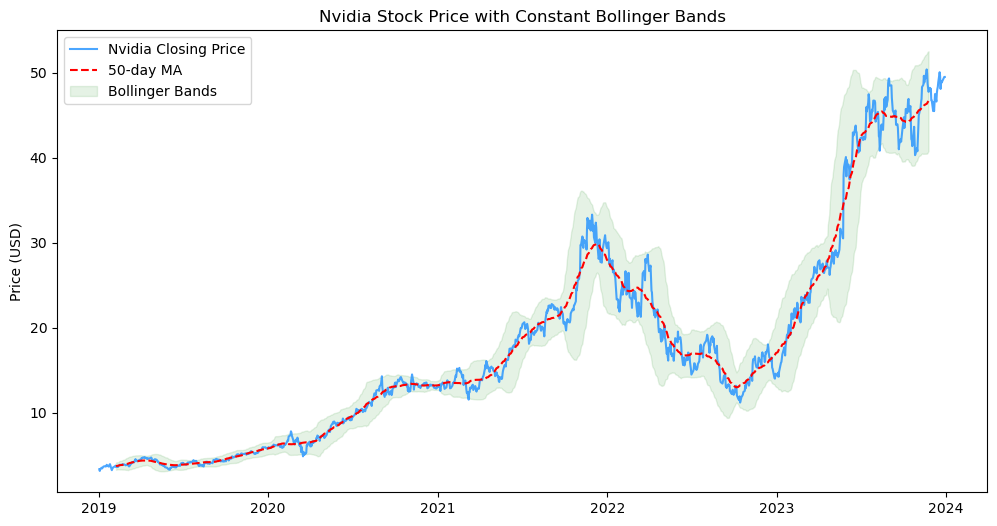

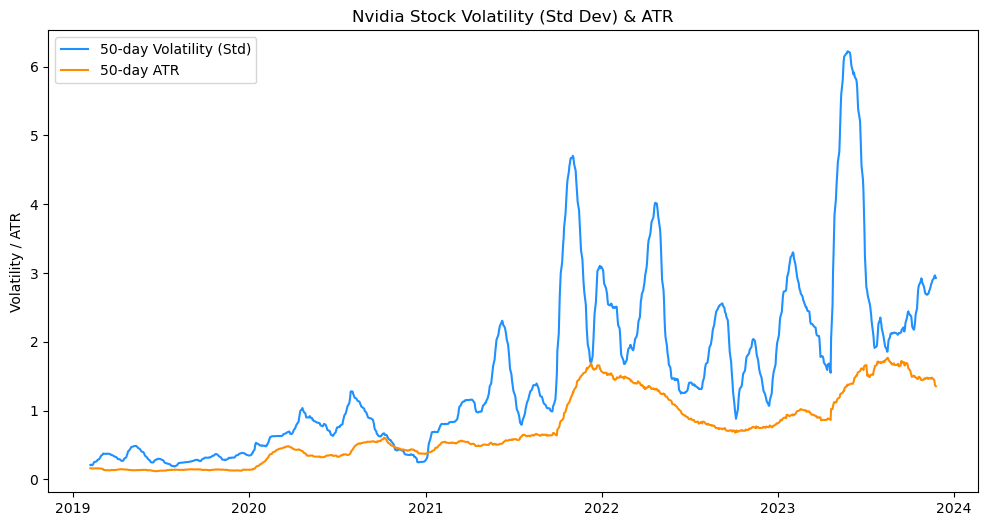

In [54]:
# Plotting Price with Bollinger Bands
fig, ax1 = plt.subplots(figsize=(12,6))

# Price & Bollinger Bands
ax1.plot(nvda.index, nvda["Close"], label="Nvidia Closing Price", color="dodgerblue", alpha=0.8)
ax1.plot(nvda.index, nvda[f"MA_{window_bb}"], label=f"{window_bb}-day MA", color="red", linestyle="--")
ax1.fill_between(nvda.index, nvda["Upper_BB"], nvda["Lower_BB"], color="green", alpha=0.1, label="Bollinger Bands")

ax1.set_ylabel("Price (USD)", color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.legend(loc="upper left")

plt.title("Nvidia Stock Price with Constant Bollinger Bands")
plt.show()

fig, ax2 = plt.subplots(figsize=(12,6))

ax2.plot(nvda.index, nvda[f"Volatility_{window_atr}"], label=f"{window_atr}-day Volatility (Std)", color="dodgerblue")
ax2.plot(nvda.index, nvda[f"ATR_{window_atr}"], label=f"{window_atr}-day ATR", color="darkorange")

ax2.set_ylabel("Volatility / ATR", color="black")
ax2.tick_params(axis='y', labelcolor="black")
ax2.legend(loc="upper left")

plt.title("Nvidia Stock Volatility (Std Dev) & ATR")
plt.show()

In [55]:
# Define a base window and a multiplier for adaptation
base_window = 20
atr_multiplier = 10  # Adjust this based on the stock's volatility

# Dynamic rolling window based on ATR (scaled)
# Doing it this way instead of using the pandas .rolling() function \
# because I need it done on a row-by-row basis
adaptive_ma = []
adaptive_std = []

ensure_column(
    nvda, 
    "Adaptive_Window", 
    lambda: (atr_multiplier / nvda[f"ATR_{window_atr}"])
                .clip(lower=10, upper=50)
                .round()
                .fillna(20)  # Default window size for NaNs
                .astype(int), 
    override=True
)


for i in range(len(nvda)):
    window = int(nvda.iloc[i]["Adaptive_Window"].values[0])  # Get the adaptive window size
    if i < window:  # Handle edge case where there's not enough data
        adaptive_ma.append(np.nan)
        adaptive_std.append(np.nan)
    else:
        subset = nvda["Close"].iloc[i - window + 1 : i + 1]  # Get the rolling window data
        adaptive_ma.append(subset.mean().values[0])
        adaptive_std.append(subset.std().values[0])

ensure_column(nvda, "Adaptive_MA", lambda: adaptive_ma, override=True)
ensure_column(nvda, "Adaptive_Std", lambda: adaptive_std, override=True)

# Calculate Bollinger Bands based on adaptive window
# Fill NaNs with the nearest available value (or use a specific method)
ensure_column(nvda, "Adaptive_Upper_BB", lambda: (nvda["Adaptive_MA"] + (nvda["Adaptive_Std"] * 2)), override=True)
ensure_column(nvda, "Adaptive_Lower_BB", lambda: (nvda["Adaptive_MA"] - (nvda["Adaptive_Std"] * 2)), override=True)

# Ensure correct datatypes
nvda["Adaptive_MA"] = pd.to_numeric(nvda["Adaptive_MA"], errors="coerce")
nvda["Adaptive_Std"] = pd.to_numeric(nvda["Adaptive_Std"], errors="coerce")
nvda["Adaptive_Upper_BB"] = pd.to_numeric(nvda["Adaptive_Upper_BB"], errors="coerce")
nvda["Adaptive_Lower_BB"] = pd.to_numeric(nvda["Adaptive_Lower_BB"], errors="coerce")

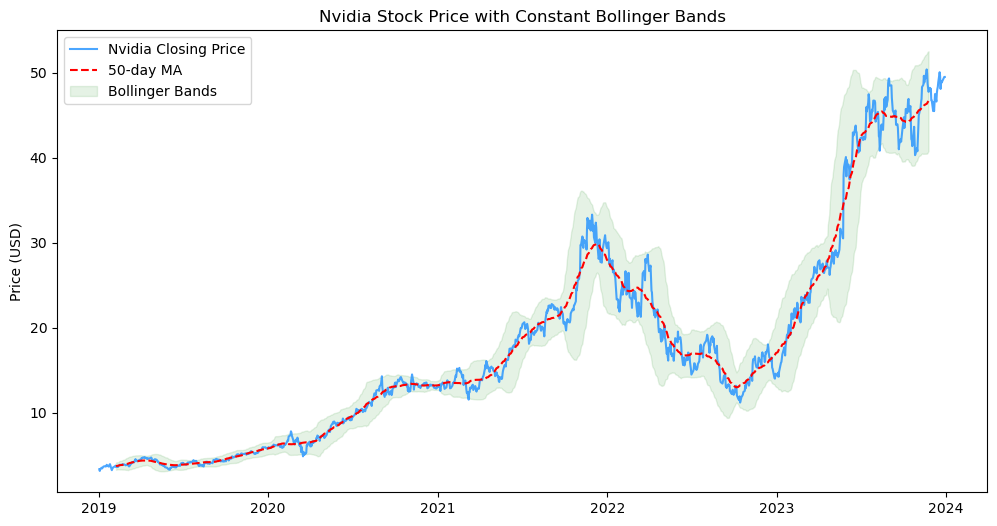

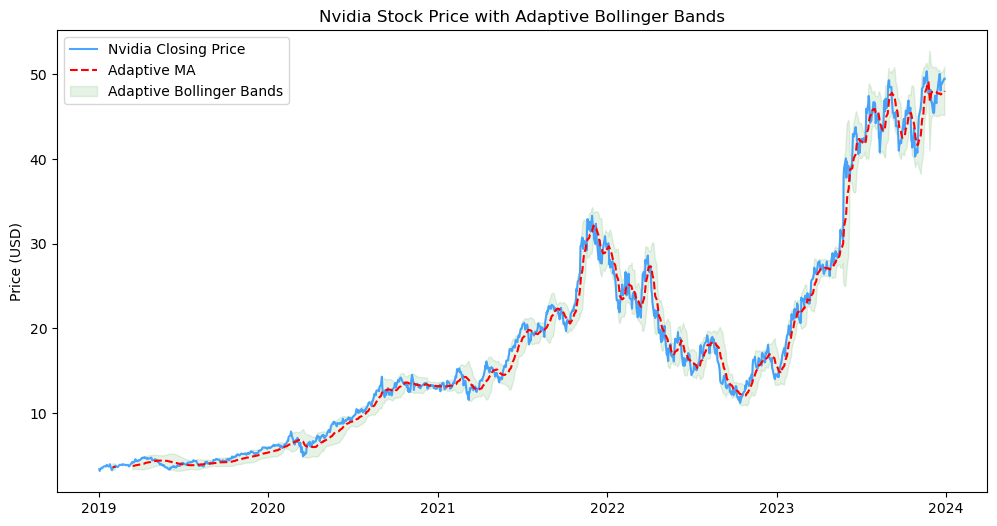

In [56]:
# Plotting Price with Bollinger Bands
fig, ax1 = plt.subplots(figsize=(12,6))

# Price & Bollinger Bands
ax1.plot(nvda.index, nvda["Close"], label="Nvidia Closing Price", color="dodgerblue", alpha=0.8)
ax1.plot(nvda.index, nvda[f"MA_{window_bb}"], label=f"{window_bb}-day MA", color="red", linestyle="--")
ax1.fill_between(nvda.index, nvda["Upper_BB"], nvda["Lower_BB"], color="green", alpha=0.1, label="Bollinger Bands")

ax1.set_ylabel("Price (USD)", color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.legend(loc="upper left")

plt.title("Nvidia Stock Price with Constant Bollinger Bands")
plt.show()

fig, ax2 = plt.subplots(figsize=(12,6))

# Price & Bollinger Bands
ax2.plot(nvda.index, nvda["Close"], label="Nvidia Closing Price", color="dodgerblue", alpha=0.8)
ax2.plot(nvda.index, nvda["Adaptive_MA"], label="Adaptive MA", color="red", linestyle="--")
ax2.fill_between(nvda.index, nvda["Adaptive_Upper_BB"], nvda["Adaptive_Lower_BB"], color="green", alpha=0.1, label="Adaptive Bollinger Bands")

ax2.set_ylabel("Price (USD)", color="black")
ax2.tick_params(axis='y', labelcolor="black")
ax2.legend(loc="upper left")

plt.title("Nvidia Stock Price with Adaptive Bollinger Bands")
plt.show()

### Thoughts

**Constant Bands Assume a Fixed Volatility**
* The 50-day Bollinger Bands don’t adjust based on recent price movement.
* They might be too wide in calm markets and too tight in volatile ones.
* This could cause misleading signals, especially when trends accelerate or slow down.

**Adaptive Bands React to Market Conditions**
* The adaptive bands adjust dynamically to periods of high and low volatility.
* They contract during steady trends and expand during volatile swings.
* This allows for better responsiveness when price action changes suddenly.

**Trade & Analysis Implications**
* Adaptive bands may be better for setting stop-losses, since they more accurately reflect market volatility at that moment.
* Constant bands may work better for long-term trend identification, as they don’t react too much to short-term swings.
* If a stock constantly rides along the upper adaptive band, it could indicate strong momentum. If it constantly touches the lower band, it might signal weakness.

## Support and Resistances

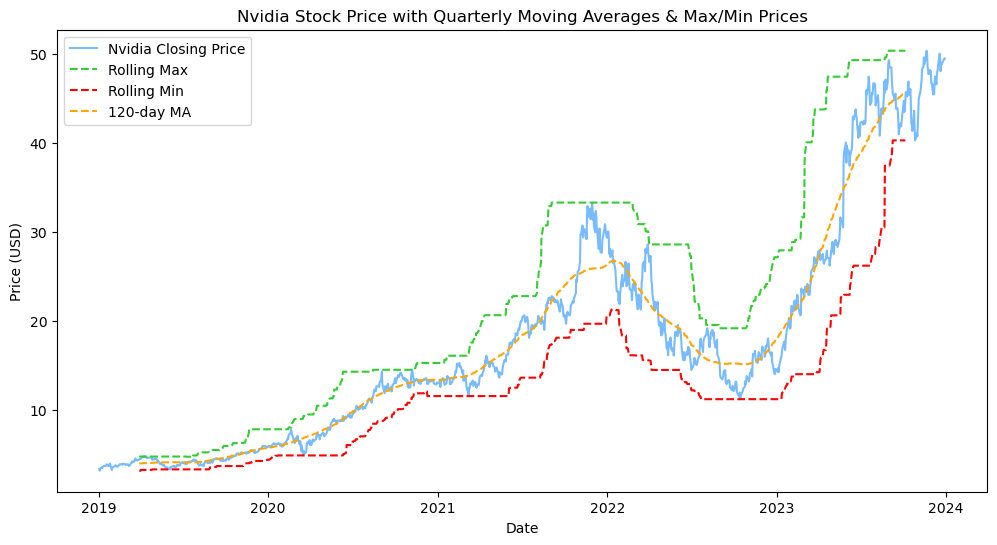

In [58]:
# Trying to see quarterly trends:
window = 120

ensure_column(nvda, f"MA_{window}", lambda: nvda["Close"].rolling(window=window, center=True).mean()) # quarterly moving average
ensure_column(nvda, "Rolling Max", lambda: nvda["Close"].rolling(window=window, center=True).max(), override=True)
ensure_column(nvda, "Rolling Min", lambda: nvda["Close"].rolling(window=window, center=True).min(), override=True)

# Plotting it all together
plt.figure(figsize=(12,6))
plt.plot(nvda["Close"], label="Nvidia Closing Price", color='dodgerblue', alpha=0.6)
plt.plot(nvda["Rolling Max"], label="Rolling Max", color='limegreen', linestyle="--")
plt.plot(nvda["Rolling Min"], label="Rolling Min", color='red', linestyle="--")
plt.plot(nvda[f"MA_{window}"], label=f"{window}-day MA", color='orange', linestyle="--")

plt.title("Nvidia Stock Price with Quarterly Moving Averages & Max/Min Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

### Thoughts

We can see here that the green and red line represent resistances and support perspectively, however in 2023 when the price broke above it, it could have been a support. To really understand these better though I'll be doing a peak and valley detection next.

## Peak & Valley Detection

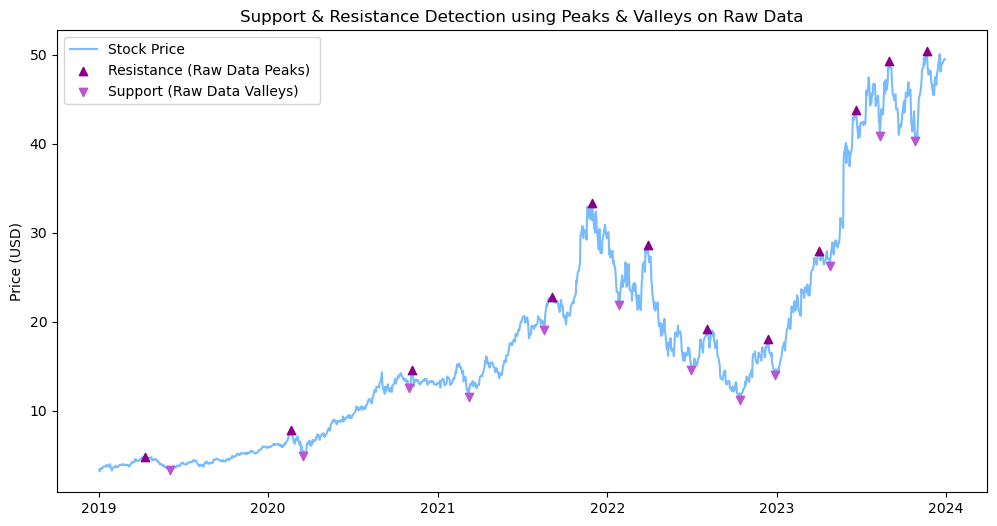

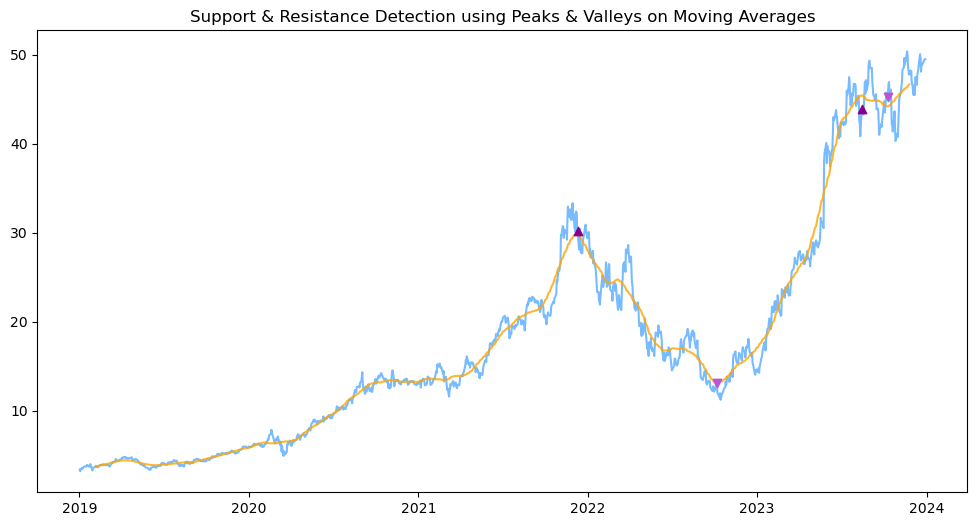

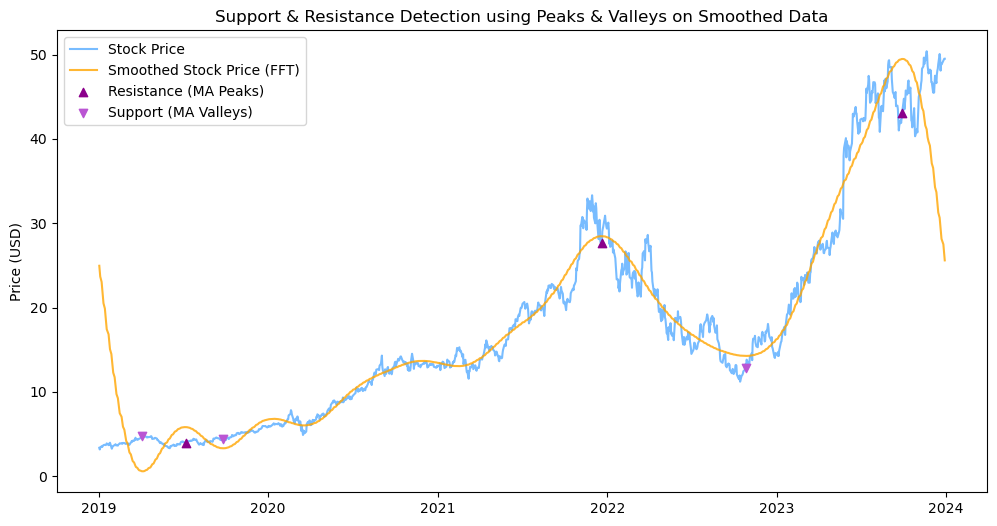

In [60]:
from scipy.signal import find_peaks
from scipy.fft import fft, ifft

distance = 50
prominence = 1

ensure_column(nvda, f"MA_{distance}", lambda: nvda["Close"].rolling(window=distance, center=True).mean(), override=True)

# Detect peaks (resistances) & valleys (supports) in closing prices (on raw data)
peaks_raw, _ = find_peaks(np.array(nvda["Close"]).reshape(-1,), distance=distance, prominence=prominence)
valleys_raw, _ = find_peaks(-np.array(nvda["Close"]).reshape(-1,), distance=distance, prominence=prominence)

distance = 50
prominence = 1
window = distance

# Detects peaks & valleys in rolling average of closing prices on a 50-day window
peaks_ma, _ = find_peaks(np.array(nvda[f"MA_{window}"]).reshape(-1,), distance=distance, prominence=prominence)
valleys_ma, _ = find_peaks(-np.array(nvda[f"MA_{window}"]).reshape(-1,), distance=distance, prominence=prominence)

distance = 100
prominence = 1

# Detects peaks & valleys using fourier transformed data
fft_coeffs = scipy.fft.fft(nvda["Close"].values.reshape(-1,)) # Apply FFT to the stock prices

# Zero out high-frequency components (keep only k frequencies)
k = 10  # Adjust k to control smoothing level
fft_coeffs[k:-k] = 0  # Remove high-frequency noise

smoothed_prices = scipy.fft.ifft(fft_coeffs).real  # Apply Inverse FFT (IFFT) to get smoothed prices, and only take real part

peaks_fft, _ = find_peaks(smoothed_prices, distance=distance, prominence=prominence)
valleys_fft, _ = find_peaks(-smoothed_prices, distance=distance, prominence=prominence)


# Plot stock price with support/resistance

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(nvda.index, nvda["Close"], label="Stock Price", color="dodgerblue", alpha=0.6, zorder=1)
ax1.scatter(nvda.index[peaks_raw], nvda["Close"].iloc[peaks_raw], color="darkmagenta", label="Resistance (Raw Data Peaks) ", marker="^", alpha=1, zorder=2)
ax1.scatter(nvda.index[valleys_raw], nvda["Close"].iloc[valleys_raw], color="mediumorchid", label="Support (Raw Data Valleys)", marker="v", alpha=1, zorder=2)
ax1.set_ylabel("Price (USD)", color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.legend(loc="upper left")
plt.title("Support & Resistance Detection using Peaks & Valleys on Raw Data")
plt.show()

fig, ax2 = plt.subplots(figsize=(12,6))
ax2.plot(nvda.index, nvda["Close"], label="Stock Price", color="dodgerblue", alpha=0.6, zorder=1)
ax2.plot(nvda.index, nvda[f"MA_{window}"], label=f"{window}-day Moving Average (MA)", color="orange", alpha=0.8, zorder=1)
ax2.scatter(nvda.index[peaks_ma], nvda["Close"].iloc[peaks_ma], color="darkmagenta", label="Resistance (MA Peaks)", marker="^", alpha=1, zorder=3)
ax2.scatter(nvda.index[valleys_ma], nvda["Close"].iloc[valleys_ma], color="mediumorchid", label="Support (MA Valleys)", marker="v", alpha=1, zorder=3)
ax3.set_ylabel("Price (USD)", color="black")
ax3.tick_params(axis='y', labelcolor="black")
ax3.legend(loc="upper left")
plt.title("Support & Resistance Detection using Peaks & Valleys on Moving Averages")
plt.show()

fig, ax3 = plt.subplots(figsize=(12,6))
ax3.plot(nvda.index, nvda["Close"], label="Stock Price", color="dodgerblue", alpha=0.6, zorder=1)
ax3.plot(nvda.index, smoothed_prices, label="Smoothed Stock Price (FFT)", color="orange", alpha=0.8, zorder=1)
ax3.scatter(nvda.index[peaks_fft], nvda["Close"].iloc[peaks_fft], color="darkmagenta", label="Resistance (MA Peaks)", marker="^", alpha=1, zorder=3)
ax3.scatter(nvda.index[valleys_fft], nvda["Close"].iloc[valleys_fft], color="mediumorchid", label="Support (MA Valleys)", marker="v", alpha=1, zorder=3)
ax3.set_ylabel("Price (USD)", color="black")
ax3.tick_params(axis='y', labelcolor="black")
ax3.legend(loc="upper left")
plt.title("Support & Resistance Detection using Peaks & Valleys on Smoothed Data")
plt.show()

### Thoughts

* **Smoothing or longer time frames reveal stronger support/resistance (SnR) levels** – These levels are more significant because they represent price levels where traders have repeatedly bought or sold in large quantities.

* **Raw price data captures short-term SnR levels** – These tend to be more reactive to immediate market conditions and can break easily.

* **Different techniques highlight different types of SnR:**
    * Moving Averages (e.g., 50-day, 200-day MA) → Act as dynamic support/resistance.
    * FFT Smoothing → Captures macro-level trend reversals.
    * Rolling max/min or peaks in raw data → Helps in spotting short-term SnR.

**-----------------------------------------------------------------------------**

**Breaking Down the Key Price Interactions:**

* Late 2021 peak → Early 2022 support → Breaks downward
    * That peak in late 2021 initially acted as resistance when price first reached it.
    * After the breakout, it flipped into support in early 2022 when price pulled back.
    * But when price dropped further, it broke that support, signaling a shift to a new range.
      
* Early 2021 valley → Became multi-timeframe SnR
    * The valley in early 2021 later became a support level in late 2022.
    * That same level, combined with smaller valleys in late 2021 and early 2022, created a range for price to bounce between throughout late 2022.
    * Price kept bouncing between those points, meaning traders were respecting those levels.
      
* Mid-to-late 2022 range → Eventually broke out in 2023
    * The support held for a while, but when price finally broke below it in late 2022, it indicated a shift downward.
    * But in 2023, price broke back above that range, confirming a reversal.

This Matters for Trading Decisions because:
* If you were trading this, you would have:
* Watched the late 2021 peak for resistance → then confirmation of support when price retested in early 2022.
* Noticed the price consolidating in late 2022 → signaling that those valleys were key SnR levels.
* Anticipated a breakout in 2023 → once price cleared above the resistance.

**The big takeaway: Previous peaks and valleys create price memory where buyers and sellers react even months later!**

📌 Additional Exploratory Analysis Before Modeling
1️⃣ 📊 Candlestick Patterns & Trend Identification

We’ve been working with closing prices, but what if we visualize candlestick patterns using open, high, low, and close (OHLC) data?
Identify bullish/bearish reversal patterns (e.g., Doji, Engulfing, Hammer, etc.).
See how these patterns align with SnR levels.
2️⃣ 📉 Trend Strength Analysis (ADX - Average Directional Index)

We can check how strong a trend is before it reverses.
The ADX indicator measures whether a trend is weak (<20) or strong (>40).
3️⃣ 📊 Volume Analysis & Money Flow Index (MFI)

How does volume behave at major peaks and valleys?
The Money Flow Index (MFI) combines volume and price movement to see if money is flowing into or out of a stock.
4️⃣ 📈 Relative Strength Index (RSI) & Overbought/Oversold Signals

RSI helps determine if a stock is overbought (>70, likely to fall) or oversold (<30, likely to rise).
We can overlay RSI on SnR zones and see if it helps confirm reversal points.
5️⃣ 🔄 Rolling Correlations with Other Stocks or Indices

Does NVDA correlate with S&P 500 or tech stocks?
Calculate a rolling correlation (e.g., 50-day correlation) with QQQ (NASDAQ ETF) or SOXX (Semiconductor ETF).
6️⃣ 📌 Seasonality & Time-Based Patterns

Do certain months or years have higher volatility?
We can break price action into quarterly or yearly trends.
7️⃣ 🔍 Anomaly Detection (Outlier Analysis)

Identify sudden, extreme price movements that might be outliers.
Use Z-scores or other methods to flag unusual spikes or crashes.